<a href="https://colab.research.google.com/github/robert-pineau/CIND-860-Capstone/blob/main/CIND860_TL_VGG19_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIND860: W24: Advanced Data Analytics Project
Robert M. Pineau
941-049-371

In [1]:
import sys
import os
import glob
import re

from google.colab import drive

import pandas as pd
import numpy as np
import math
import random
import cv2
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import layers
from keras.layers import Dropout
from keras import models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

device_names = tf.config.list_physical_devices('GPU')
print(device_names)

if tf.test.gpu_device_name() != "/device:GPU:0":
  print("raise SystemError('GPU device not found')")
print('Found GPU at: {}'.format(device_names))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found GPU at: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#Data Generator, this is used to provide to the training(fit) method
#one batch of data at a time.  This is needed because all of the data cannot fit into memory at the same
#time, so it needs to be loaded by the batch.
#
#This uses a custom class for this, with expected standard methods __init__, __len__, and __getitem__
#The __init__ method simply sets some internal values us batch size, overall lengths, etc.
#
#The __len__ method returns the number of batches.
#The __getitem__  method loads from file the appropriatte batch: X(the image), and Y(the class variable) and
#returns it to the fit method.
class DataGenerator(keras.utils.Sequence):
  def __init__(self, cnn_use, numpy_dir, total_size, batch_size=12):
    self.cnn_use = cnn_use
    self.total_size = total_size
    self.batch_size = batch_size
    self.numpy_dir = numpy_dir

  def __len__(self):
    return int(self.total_size / self.batch_size)

  def __getitem__(self, subset_index):
    X = np.load(f"{self.numpy_dir}/{self.cnn_use}_data_X_{subset_index}.npy")
    Y = np.load(f"{self.numpy_dir}/{self.cnn_use}_data_Y_{subset_index}.npy")
    return X, Y



#These two methods work very similarly to __getitem__ above,
#but are not part of the DataGenerator Class.  They are used to be
#able to extract the test and validate data itself in order to perform
#manual checks on the algorithms performance(using predict, instead of evaluate)

def get_test_X_Y_Z(numpy_dir, subset_index):
    X = np.load(f"{numpy_dir}/test_data_X_{subset_index}.npy")
    Y = np.load(f"{numpy_dir}/test_data_Y_{subset_index}.npy")
    Z = np.load(f"{numpy_dir}/test_data_Z_{subset_index}.npy")
    return X, Y, Z

def get_val_X_Y_Z(numpy_dir, subset_index):
    X = np.load(f"{numpy_dir}/validate_data_X_{subset_index}.npy")
    Y = np.load(f"{numpy_dir}/validate_data_Y_{subset_index}.npy")
    Z = np.load(f"{numpy_dir}/validate_data_Z_{subset_index}.npy")
    return X, Y, Z

In [3]:
#Previously all training, validate, and test data was loaded from image files and saved in numpy format in batches of 12.
#This grabs those numpy files from my google drive and copies them to the runtime drive for this session.
#Do it this way the "dataGenerator" is able to load the data from the local machine to save time during training, validation, and testing.
!date
drive.mount('/content/drive',force_remount=True)
my_dir = "attempt9"
remote_image_dir = f"/content/drive/MyDrive/Colab Notebooks/{my_dir}"
remote_numpy_dir = remote_image_dir
glob_string = f"{remote_numpy_dir}/*.npy"
local_numpy_dir = "/tmp/rpineau_numpy"
os.system(f"mkdir {local_numpy_dir}")


#numpy_list = glob.glob(os.path.join("", glob_string))
#i=0
#for numpy_name in numpy_list:
#  results = re.search(r"((train)|(test)|(validate))\_data_((X)|(Y))\_(\d+).npy", numpy_name)
#  os.system(f"cp \"{numpy_name}\" \"{local_numpy_dir}/{results[1]}_data_{results[5]}_{results[8]}.npy\"")
#  if i%20 == 0:
#    print(f"Copied {i} numpy files of {len(numpy_list)}")
#  i = i+1

#Had to abandon the PYTHON way above, due to it taking over an hour to transfer all the numpy files.
#however, even worse on many attempts it froze, and did not work.
#After tar & gzip the files, the below shell commands are more reliable, and much quicker.
#(13 minutes versus over an hour)
#Due to the fact gzip compression achieves a nearly 90% compression ratio.

os.system(f"cd \"{remote_numpy_dir}\" && cp train.tgz /tmp/rpineau_numpy/train.tgz")
os.system(f"cd \"{remote_numpy_dir}\" && cp validate.tgz /tmp/rpineau_numpy/validate.tgz")
os.system(f"cd \"{remote_numpy_dir}\" && cp test.tgz /tmp/rpineau_numpy/test.tgz")

os.system(f"cd \"{local_numpy_dir}\" && /usr/bin/tar -zxpvf train.tgz")
os.system(f"cd \"{local_numpy_dir}\" && /usr/bin/tar -zxpvf validate.tgz")
os.system(f"cd \"{local_numpy_dir}\" && /usr/bin/tar -zxpvf test.tgz")

!date

Sat Mar 30 03:19:59 PM UTC 2024
Mounted at /content/drive
Sat Mar 30 03:22:39 PM UTC 2024


In [4]:
#Need to count the entries contained in all the numpy files.
#Z contains the original image_id.
#Since Z is easy to load, only count Z.

these_counts = {"train":0,"validate":0,"test":0}

for i in ["train","validate","test"]:
  glob_string = f"{local_numpy_dir}/{i}_data_Z_*.npy"
  np_list = glob.glob(os.path.join("", glob_string))
  for n in np_list:
    thisZ = np.load(n)
    these_counts[i] += len(thisZ)

print(f"{these_counts}")

{'train': 20604, 'validate': 456, 'test': 456}


In [5]:
#Initialize the train, validate, and test  DataGenerators(as explained above in the class definition)
training_generator = DataGenerator("train",local_numpy_dir,these_counts["train"],batch_size=12)
validation_generator = DataGenerator("validate",local_numpy_dir,these_counts["validate"],batch_size=12)
test_generator = DataGenerator("test",local_numpy_dir,these_counts["test"],batch_size=12)

Load VGG19, and use it as the basis for this CNN

In [6]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50

input_shape = (224, 224, 3)
vgg19_model = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")
vgg19_model.summary()

#Note:  above, "include_top=False" was used, so the VGG19 model will only contain the CNN portion, not the Dense NN portion.

80134624/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [7]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
#Create the actual model to be trained, using VGG19 as the base, with a custom fully connected(Dense) NN after.
model = models.Sequential()
model.add(vgg19_model)
model.add(Flatten())
for i in range(12,9,-1):
  model.add(Dense(2**i, activation= 'relu'))
  model.add(Dropout(0.5))

# binary classification, using a final layer with 1 output and sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.0000001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2

In [9]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath=f"{remote_numpy_dir}/keras_cnn_model.keras",
    save_best_only=True,
    monitor="val_loss"
)]

#Train the model for 200 epochs
model_history = model.fit(training_generator, validation_data=validation_generator, epochs=200, callbacks=callbacks)

test_loss,test_acc = model.evaluate(test_generator)
print(f"MODEL1: Test Loss: {np.round(test_loss,3)} Test Accuracy: {np.round(test_acc*100,3)}%")

Epoch 1/200
1717/1717 [==============================] - 165s 89ms/step - loss: 0.8560 - accuracy: 0.5021 - val_loss: 0.7201 - val_accuracy: 0.5132
Epoch 2/200
1717/1717 [==============================] - 138s 80ms/step - loss: 0.8230 - accuracy: 0.5015 - val_loss: 0.7187 - val_accuracy: 0.5132
Epoch 3/200
1717/1717 [==============================] - 138s 80ms/step - loss: 0.8095 - accuracy: 0.5005 - val_loss: 0.7150 - val_accuracy: 0.5132
Epoch 4/200
1717/1717 [==============================] - 138s 80ms/step - loss: 0.7951 - accuracy: 0.5055 - val_loss: 0.7122 - val_accuracy: 0.5132
Epoch 5/200
1717/1717 [==============================] - 138s 80ms/step - loss: 0.7831 - accuracy: 0.5068 - val_loss: 0.7069 - val_accuracy: 0.5132
Epoch 6/200
1717/1717 [==============================] - 138s 80ms/step - loss: 0.7756 - accuracy: 0.5068 - val_loss: 0.7051 - val_accuracy: 0.5132
Epoch 7/200
1717/1717 [==============================] - 137s 80ms/step - loss: 0.7669 - accuracy: 0.5073 - val_

In [12]:
this_dir = f"{local_numpy_dir}"

Y_test_all = []
Y_all = []
Z_all = []

for i in range(0,int(these_counts["test"]/12)):
  X,Y,Z = get_test_X_Y_Z(this_dir,i)
  Y_test = model.predict(X, verbose=0)
  Y_test = np.round(Y_test).flatten()
  Y_test_all = np.append(Y_test_all,Y_test,axis=0)
  Y_all = np.append(Y_all,Y,axis=0)
  Z_all = np.append(Z_all,Z,axis=0)

n=0
for y in Y_test_all:
  print(f"Predicted Y is {Y_test_all[n]} Actual Y is {Y_all[n]} from file {Z_all[n]}")
  n = n+1


Predicted Y is 1.0 Actual Y is 0.0 from file /mnt/wd/CIND860/database/attempt4/test/47725_477593121_0.png
Predicted Y is 1.0 Actual Y is 1.0 from file /mnt/wd/CIND860/database/attempt4/test/729_730395278_0.png
Predicted Y is 1.0 Actual Y is 1.0 from file /mnt/wd/CIND860/database/attempt4/test/15078_1167308429_0.png
Predicted Y is 0.0 Actual Y is 0.0 from file /mnt/wd/CIND860/database/attempt4/test/39085_1699059177_0.png
Predicted Y is 1.0 Actual Y is 1.0 from file /mnt/wd/CIND860/database/attempt4/test/25550_1138491602_0.png
Predicted Y is 1.0 Actual Y is 0.0 from file /mnt/wd/CIND860/database/attempt4/test/21657_1453039537_0.png
Predicted Y is 1.0 Actual Y is 1.0 from file /mnt/wd/CIND860/database/attempt4/test/27344_2060786840_0.png
Predicted Y is 0.0 Actual Y is 1.0 from file /mnt/wd/CIND860/database/attempt4/test/7053_888903661_0.png
Predicted Y is 0.0 Actual Y is 0.0 from file /mnt/wd/CIND860/database/attempt4/test/25161_1531947883_0.png
Predicted Y is 0.0 Actual Y is 0.0 from fil

In [11]:
print("CORRECT PREDS")
n=0
for y in Y_all:
  if Y_test_all[n] == Y_all[n]:
    #print(f"Predicted Y is {Y_test_all[n]} Actual Y is {Y_all[n]} File {Z_all[n]}")
    print(f"{Z_all[n]}")
  n = n+1

print("INCORRECT PREDS")
n=0
for y in Y_all:
  if Y_test_all[n] != Y_all[n]:
    #print(f"Predicted Y is {Y_test_all[n]} Actual Y is {Y_all[n]} File {Z_all[n]}")
    print(f"{Z_all[n]}")
  n = n+1


CORRECT PREDS
/mnt/wd/CIND860/database/attempt4/test/729_730395278_0.png
/mnt/wd/CIND860/database/attempt4/test/15078_1167308429_0.png
/mnt/wd/CIND860/database/attempt4/test/39085_1699059177_0.png
/mnt/wd/CIND860/database/attempt4/test/25550_1138491602_0.png
/mnt/wd/CIND860/database/attempt4/test/27344_2060786840_0.png
/mnt/wd/CIND860/database/attempt4/test/25161_1531947883_0.png
/mnt/wd/CIND860/database/attempt4/test/44169_1578297799_0.png
/mnt/wd/CIND860/database/attempt4/test/32082_977001550_0.png
/mnt/wd/CIND860/database/attempt4/test/26273_717323131_0.png
/mnt/wd/CIND860/database/attempt4/test/31745_1974157960_0.png
/mnt/wd/CIND860/database/attempt4/test/38785_394129956_0.png
/mnt/wd/CIND860/database/attempt4/test/62759_590872_0.png
/mnt/wd/CIND860/database/attempt4/test/21445_1790818978_0.png
/mnt/wd/CIND860/database/attempt4/test/21067_715321439_0.png
/mnt/wd/CIND860/database/attempt4/test/52985_266488118_0.png
/mnt/wd/CIND860/database/attempt4/test/61490_1437239083_0.png
/mnt/w

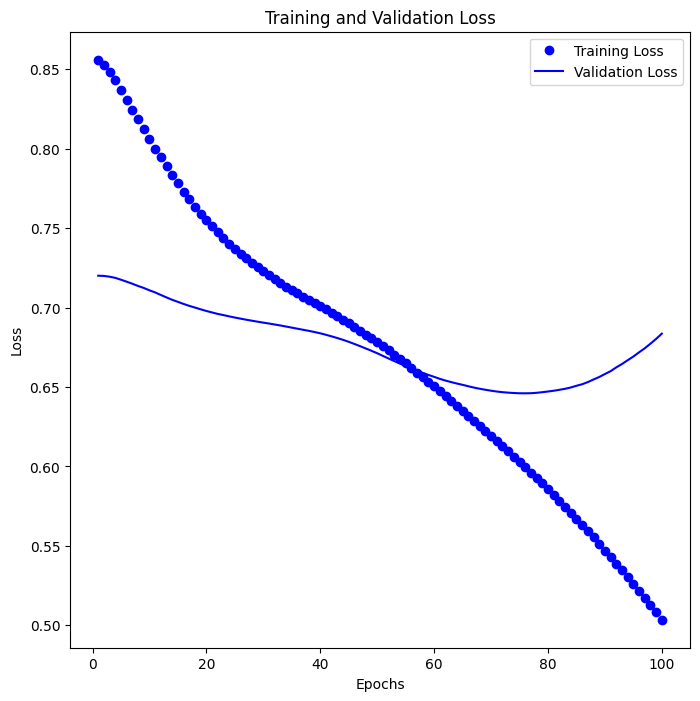

In [23]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


plt.figure(figsize=(8,8))

average_loss_history = model_history.history['loss']
average_val_loss_history = model_history.history['val_loss']
smooth_loss_history = smooth_curve(average_loss_history)
smooth_val_loss_history = smooth_curve(average_val_loss_history)

plt.plot(range(1, len(smooth_loss_history) - 99), smooth_loss_history[0:100],'bo',label='Training Loss')
plt.plot(range(1, len(smooth_val_loss_history) - 99), smooth_val_loss_history[0:100],'b',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
png_plot=f"{remote_numpy_dir}/epochs.png"
plt.savefig(png_plot)